In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [7]:
SEED = 55

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/vehicle.csv')
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [10]:
df.isna().sum()

,0
compactness,0
circularity,5
distance_circularity,4
radius_ratio,6
pr.axis_aspect_ratio,2
max.length_aspect_ratio,0
scatter_ratio,1
elongatedness,1
pr.axis_rectangularity,3
max.length_rectangularity,0


In [11]:
# percent of records with missing values.

np.round(df.isna().any(axis='columns').sum()/len(df),2)

0.04

In [12]:
# Since the number of missing values in total and for each column is less than 5%, I removed them.

df = df.dropna().reset_index(drop=True)
len(df)

813

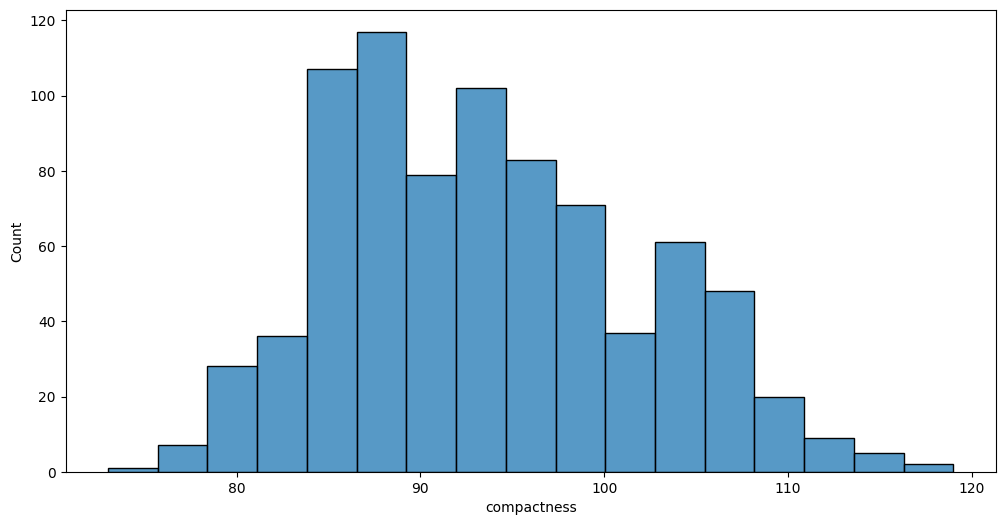

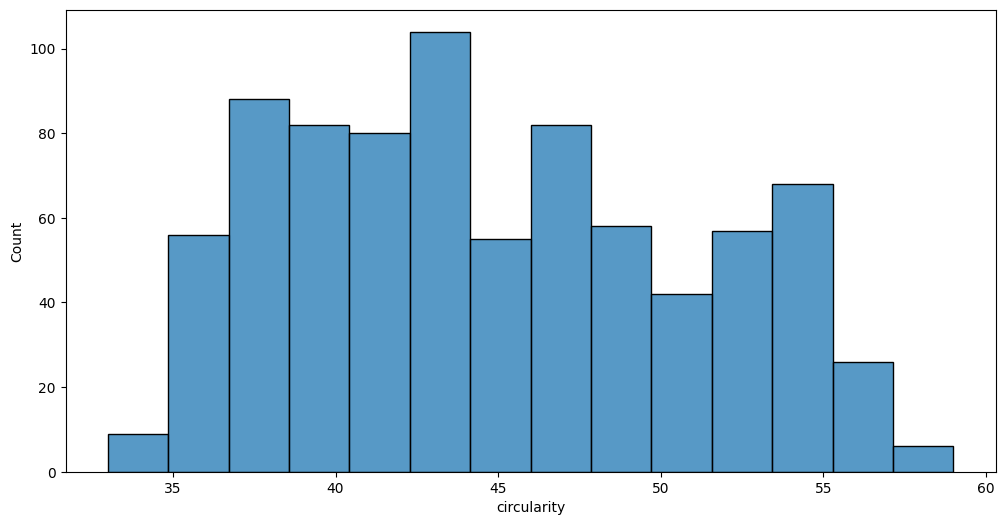

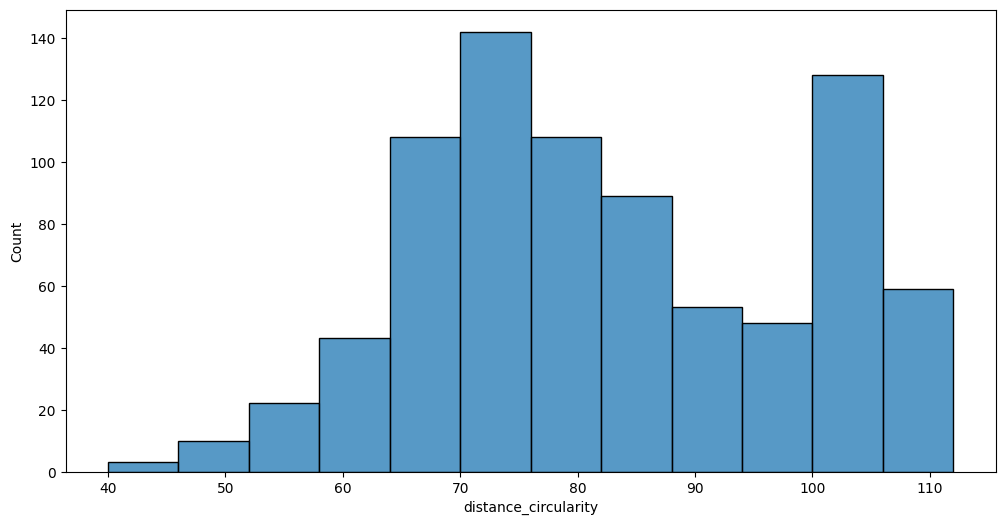

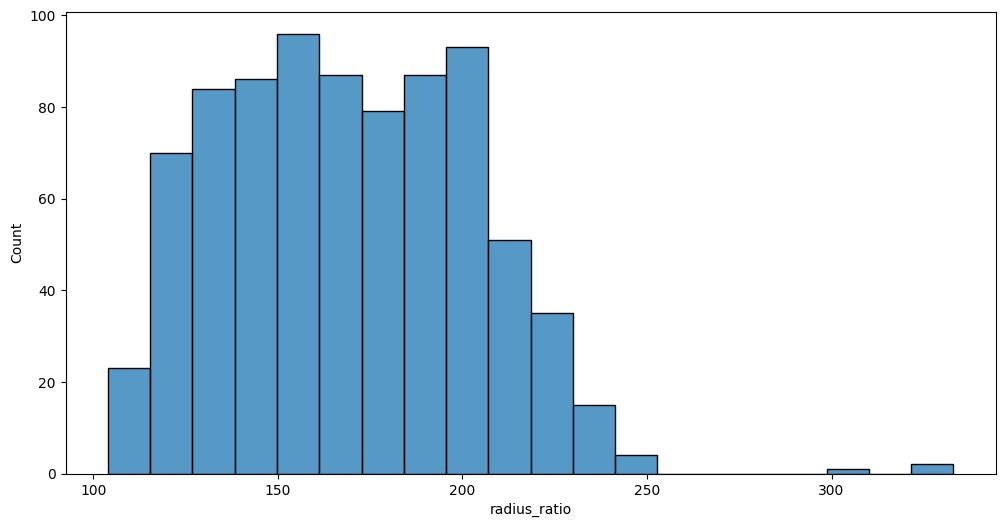

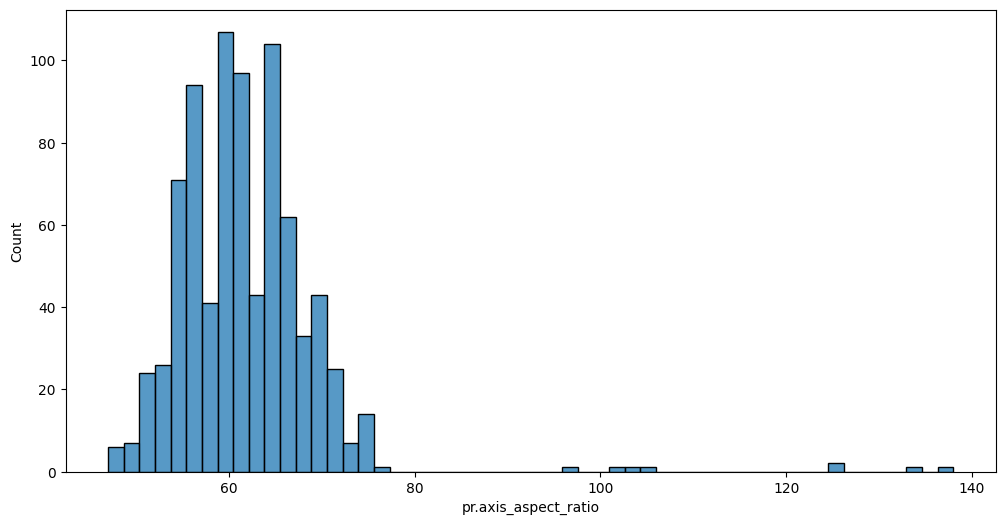

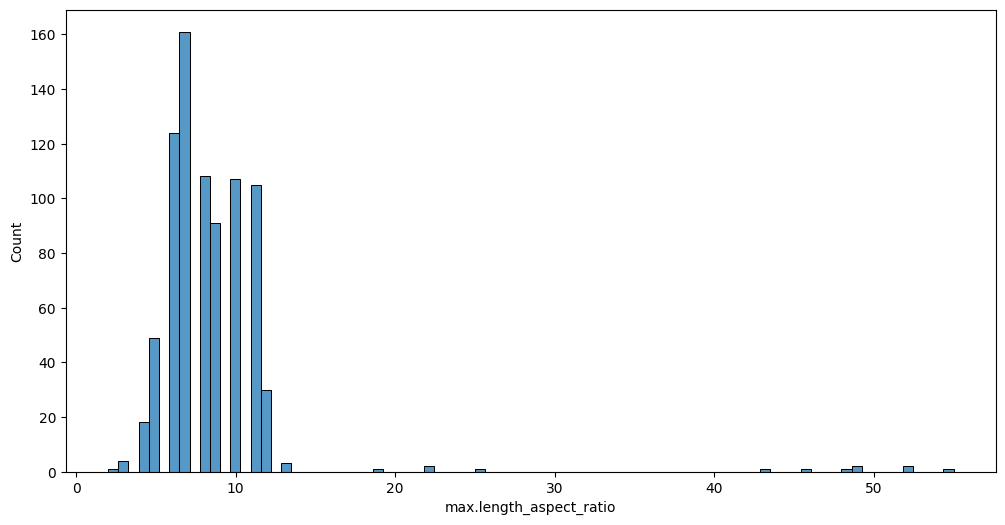

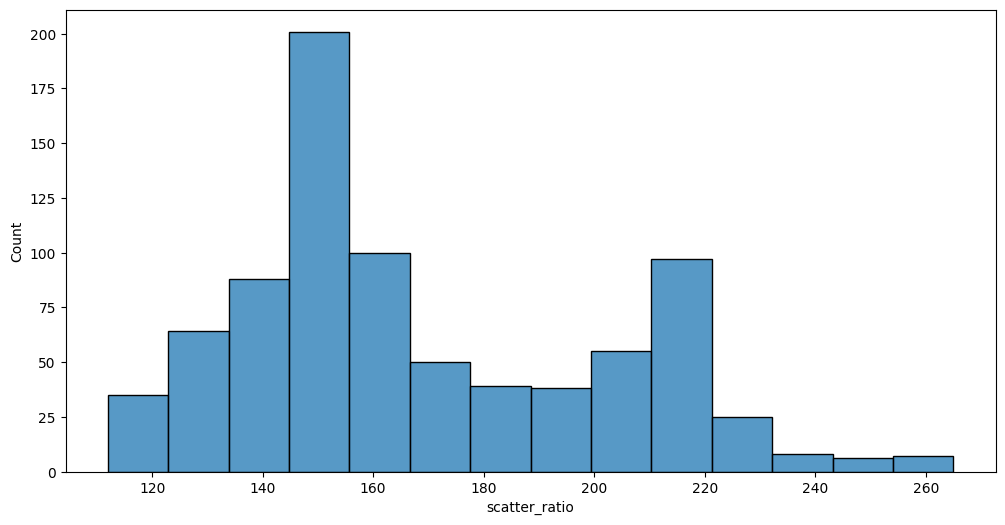

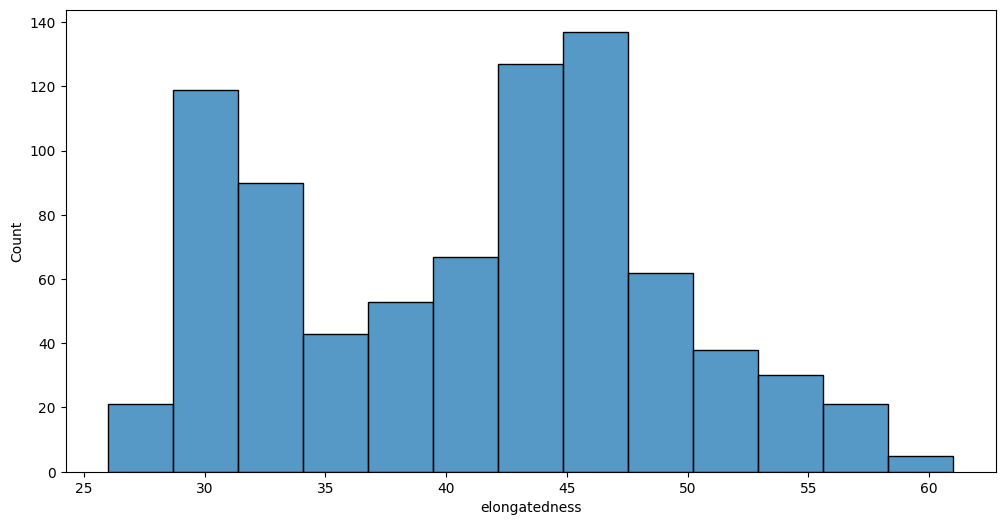

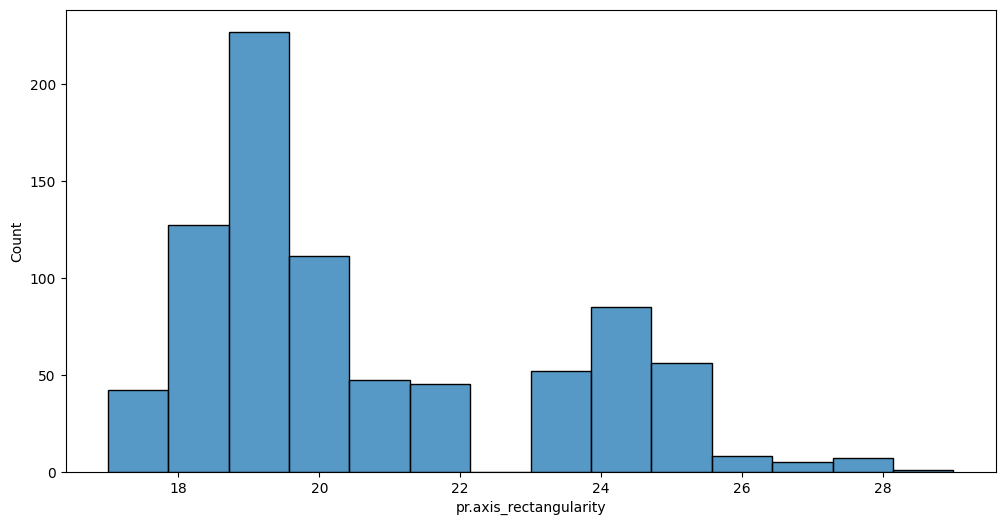

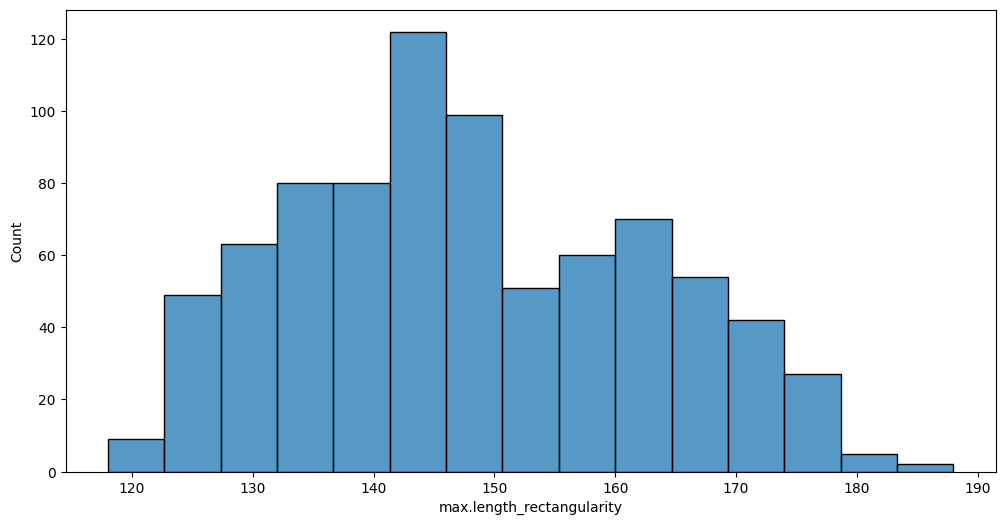

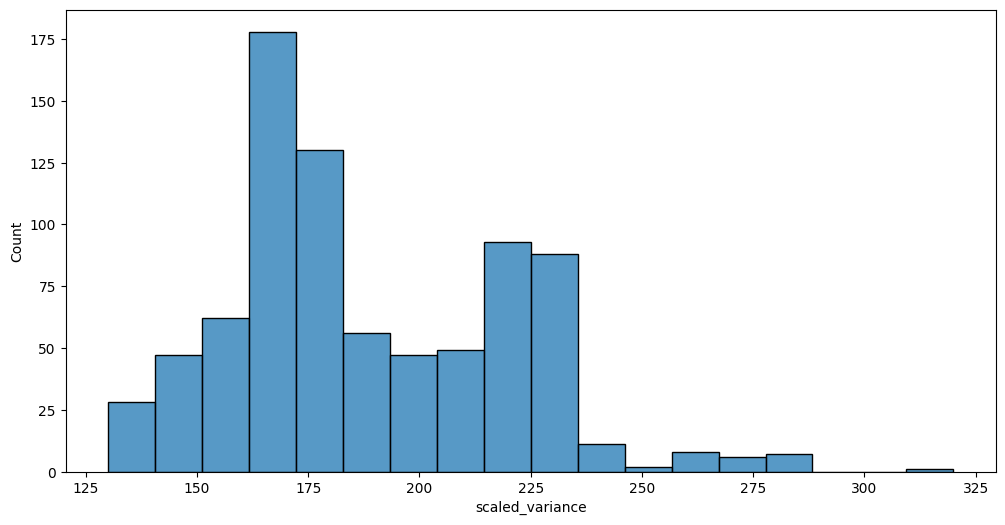

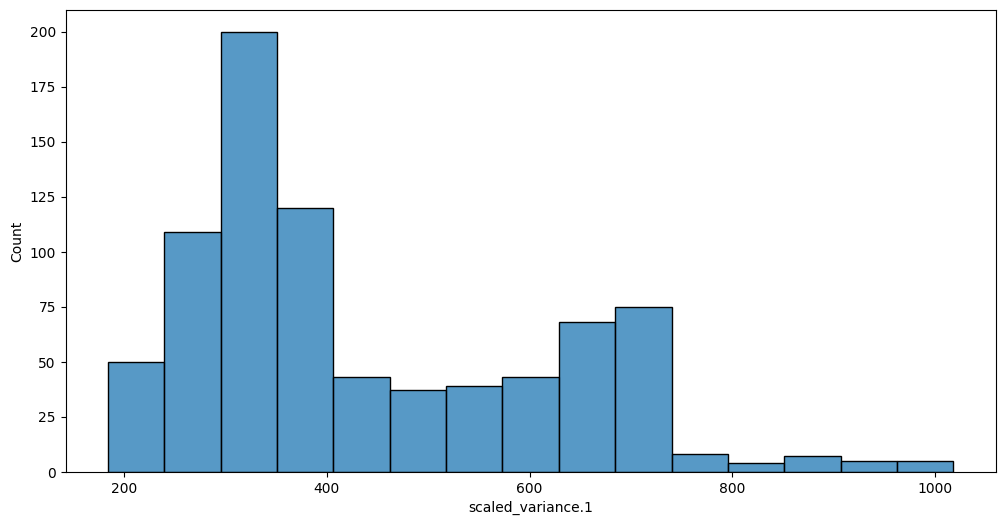

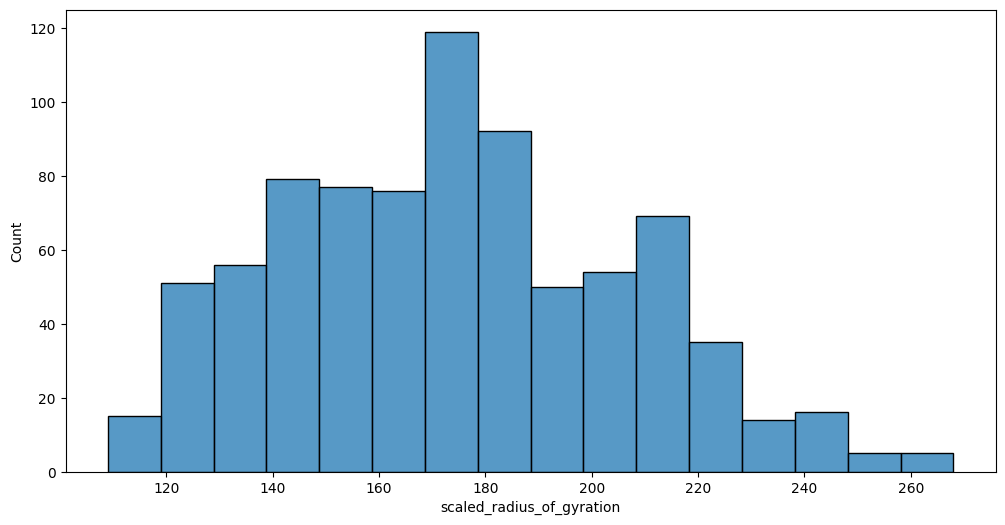

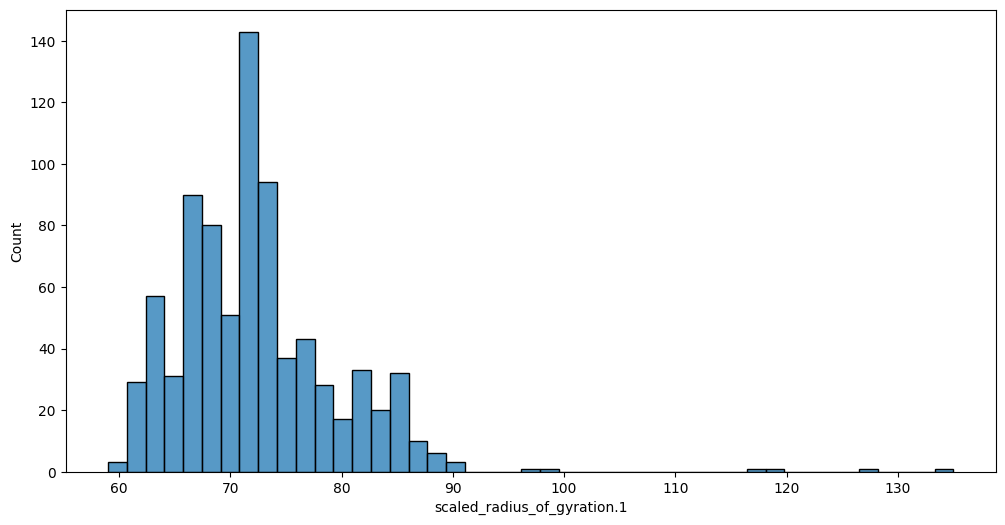

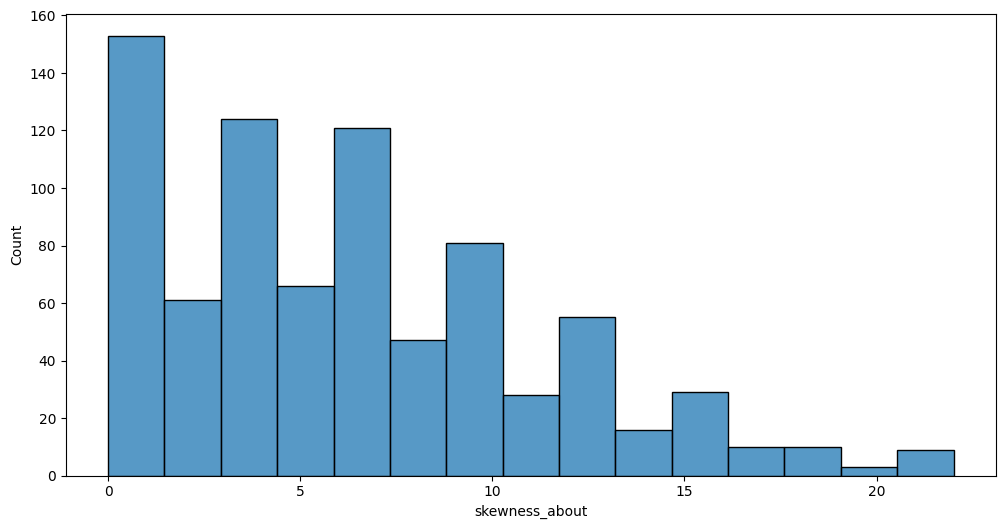

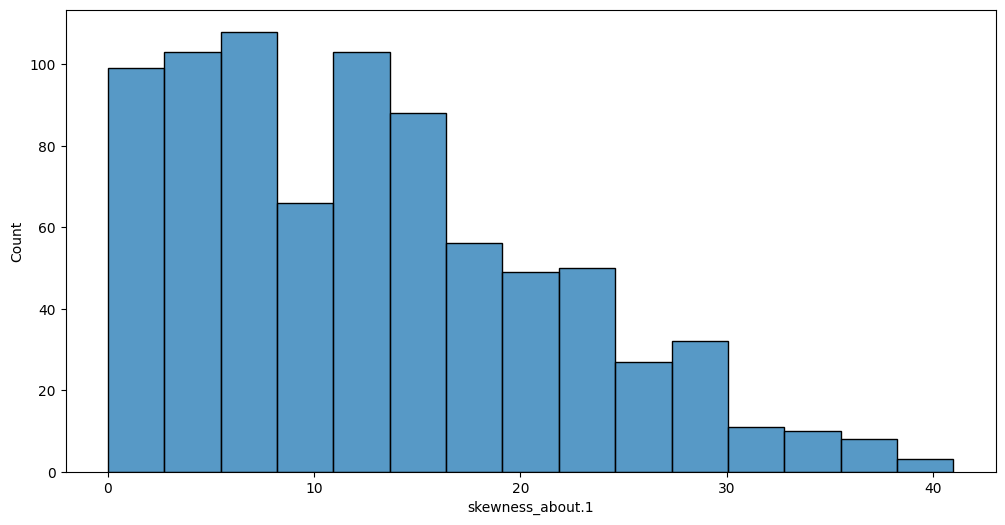

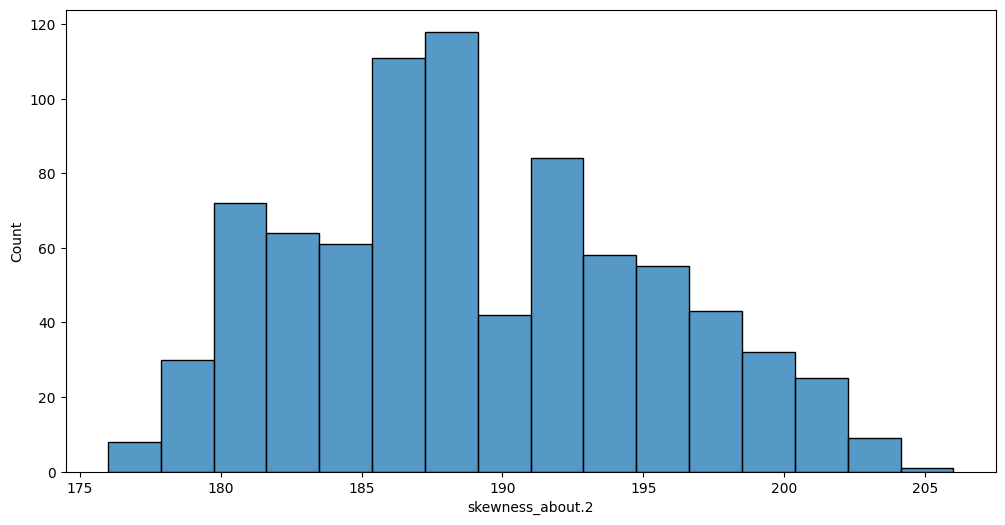

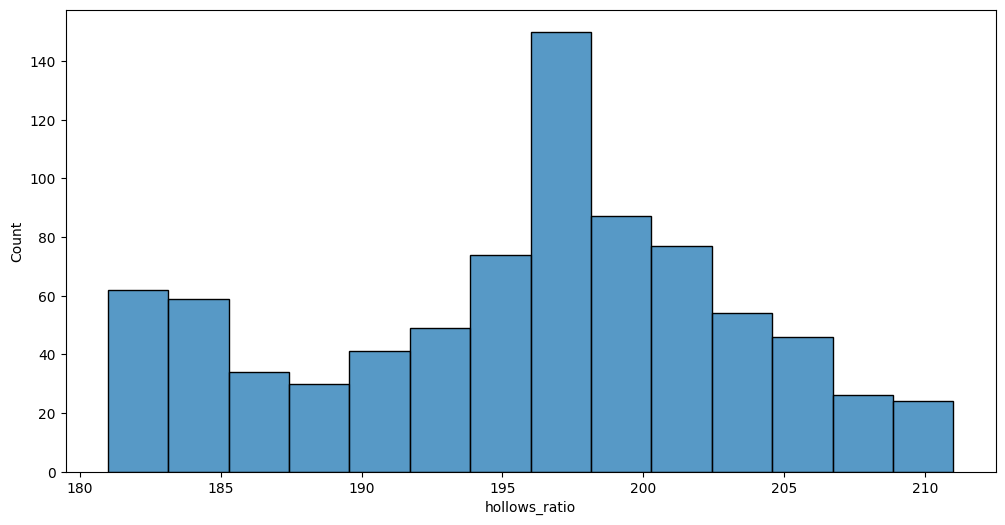

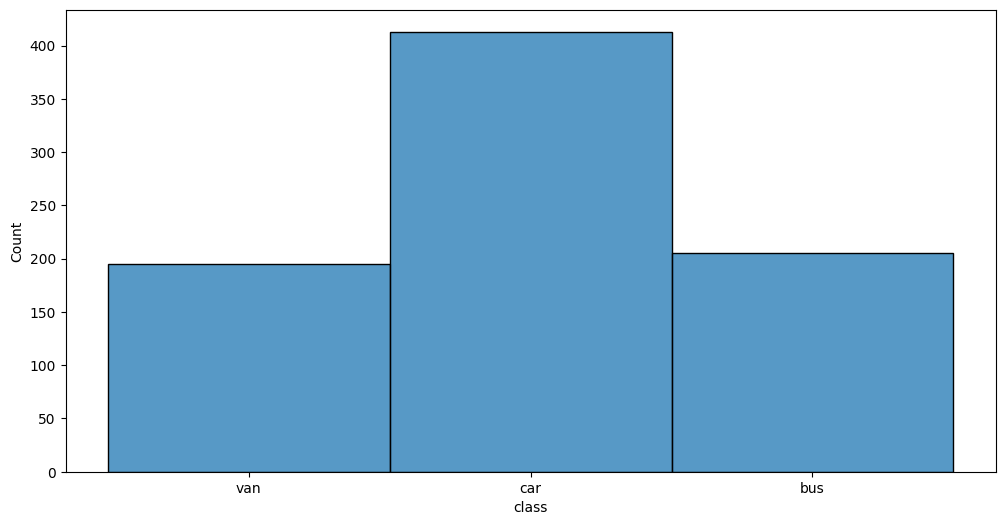

In [13]:
for col in df.columns:
  plt.figure(figsize=(12,6))
  sns.histplot(data=df,x=col)
plt.show()

In [14]:
X = df.drop('class', axis=1)
y = df['class']

In [15]:
# checking possible Multicollinearity:

vif_data = pd.DataFrame()
vif_data['features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,features,VIF
0,compactness,710.870399
1,circularity,2759.145392
2,distance_circularity,401.927622
3,radius_ratio,993.196814
4,pr.axis_aspect_ratio,968.127933
5,max.length_aspect_ratio,16.153592
6,scatter_ratio,11789.895243
7,elongatedness,952.791014
8,pr.axis_rectangularity,5869.095877
9,max.length_rectangularity,2665.255577


<Axes: >

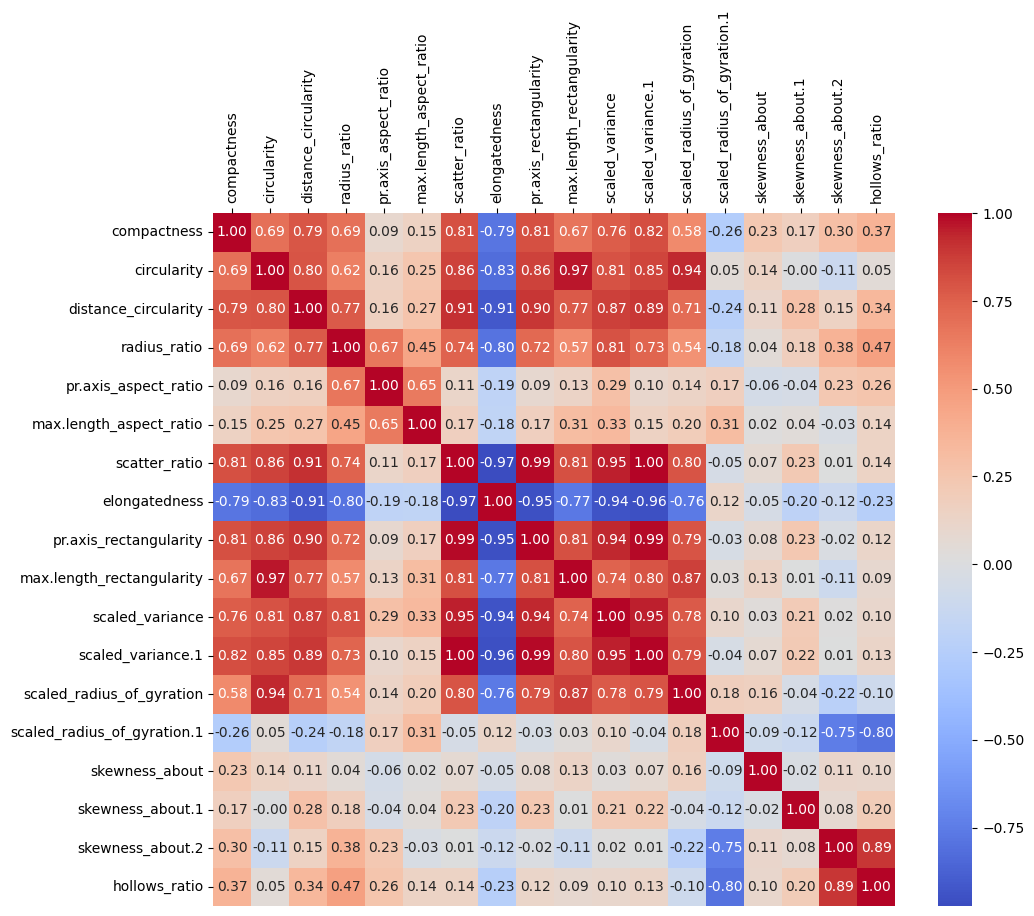

In [16]:
# checking correlation heatmap:

palette = sns.color_palette("coolwarm", as_cmap=True)

plt.figure(figsize=(11,9))
plt.xticks(rotation=90)  # Rotate labels if needed for readability
plt.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
sns.heatmap(df.drop('class', axis=1).corr(),
            annot=True,
            fmt='.2f',
            cmap = palette)

In [17]:
# To check if stratifying is needed:

y.value_counts(normalize=True)

,proportion
class,
car,0.507995
bus,0.252153
van,0.239852


In [18]:
le = LabelEncoder()
class_labels = le.classes_
y_encoded = pd.Series(le.fit_transform(y), name=y.name)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=SEED)

In [19]:
# Using RobustScaler to reduce the effect of the detected outliers

scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [20]:
# PCA was tested and got a lower accuracy score as a result, therefore is removed from process

'''pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)'''

'pca = PCA(n_components=0.95)\nX_train_pca = pca.fit_transform(X_train_scaled)\nX_test_pca = pca.transform(X_test_scaled)'

In [103]:
# finding the right hyperparameter (since the dataset is so small, it can be used in a loop):

accuracy_dict = {}

for i in range(1,201):
  logreg = LogisticRegression(C=i, max_iter=200)
  logreg.fit(X_train_scaled, y_train)
  y_test_predict = logreg.predict(X_test_scaled)
  test_accuracy = np.round(accuracy_score(y_test, y_test_predict), 3)
  accuracy_dict[i] = test_accuracy

max_value = max(accuracy_dict.values())
max_key = [key for key, value in accuracy_dict.items() if value == max_value][0]
print(max_key)

63


In [104]:
logreg = LogisticRegression(C=max_key, max_iter=200)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=63, max_iter=200)

In [128]:
# creating a function to evaluate the performance of ML models:
def evaluate_model(model, X_test, y_test):
  y_test_predict = model.predict(X_test_scaled)
  test_accuracy = np.round(accuracy_score(y_test, y_test_predict), 3)
  print(f'accuracy score : {test_accuracy}')
  cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict), index=class_labels, columns=class_labels)
  print('\nConfusion Matrix:')
  display(cm)
  performance_params = pd.DataFrame([precision_score(y_test, y_test_predict, average=None),
                                    recall_score(y_test, y_test_predict, average=None),
                                    f1_score(y_test, y_test_predict, average=None)],
                                    index=['Precision_score', 'Recall_score', 'F1_score'],
                                    columns=class_labels)
  display(performance_params)

In [129]:
y_train_predict = model.predict(X_train_scaled)
train_accuracy = np.round(accuracy_score(y_train, y_train_predict), 3)
print(train_accuracy)

evaluate_model(logreg, X_test_scaled, y_test)

0.985
accuracy score : 0.969

Confusion Matrix:


,bus,car,van
bus,38,3,0
car,1,81,1
van,0,0,39


,bus,car,van
Precision_score,0.974359,0.964286,0.975000
Recall_score,0.926829,0.975904,1.000000
F1_score,0.950000,0.970060,0.987342


<Axes: ylabel='Count'>

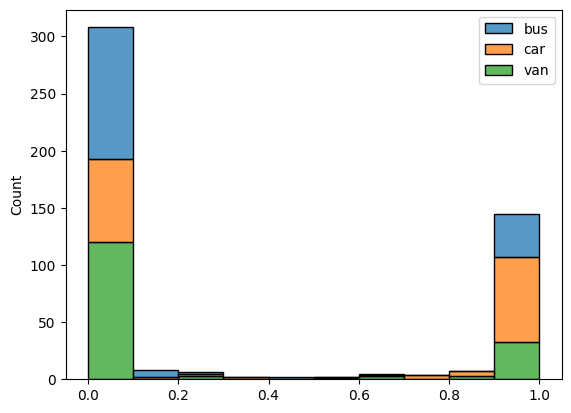

In [26]:
probabilities = pd.DataFrame(model.predict_proba(X_test_scaled), columns=class_labels)
sns.histplot(probabilities, multiple='stack')

All of the Performance parameters are pointing that the model performance is acceptable.

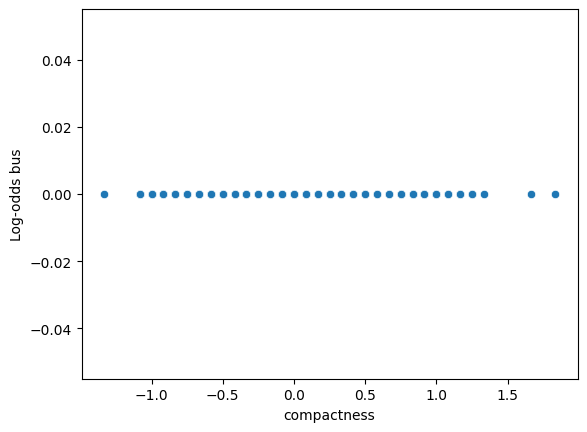

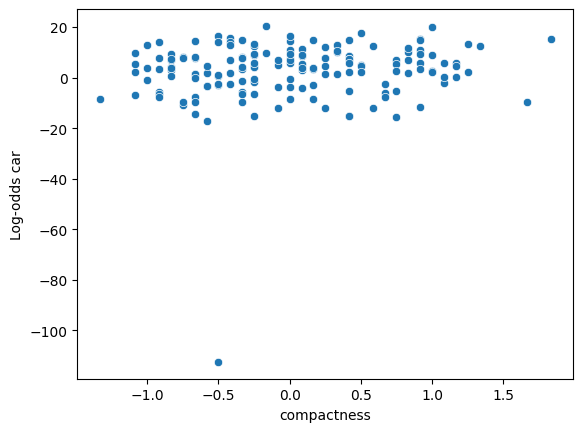

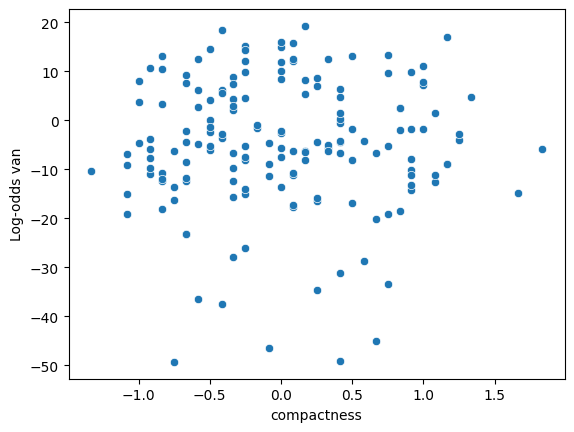

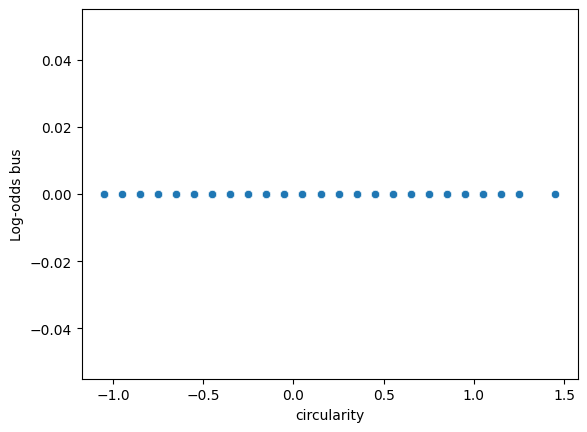

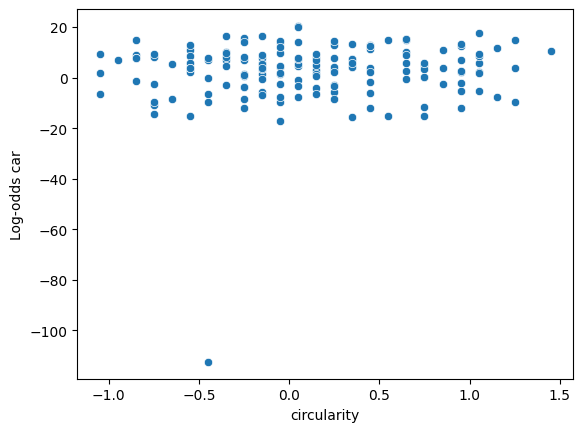

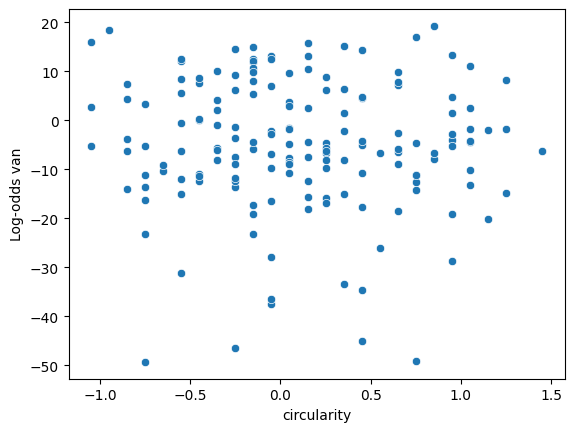

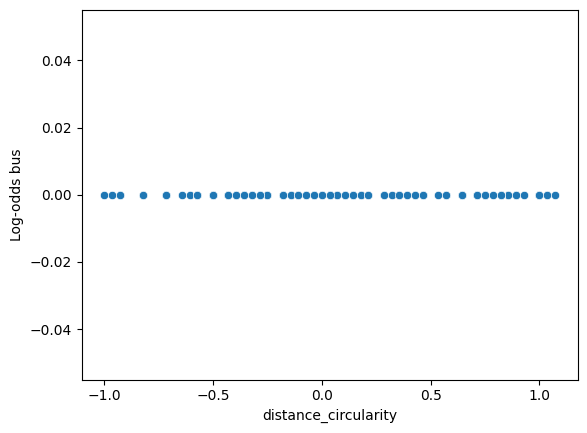

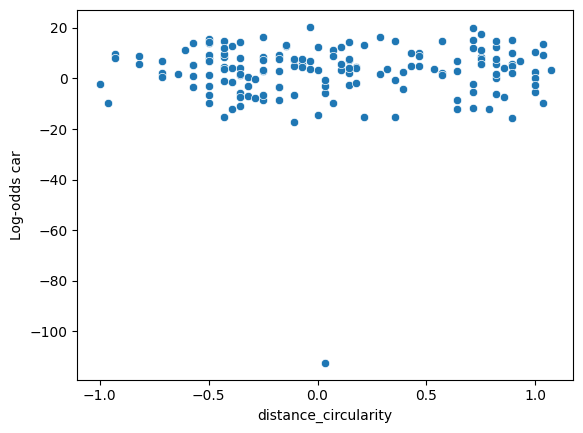

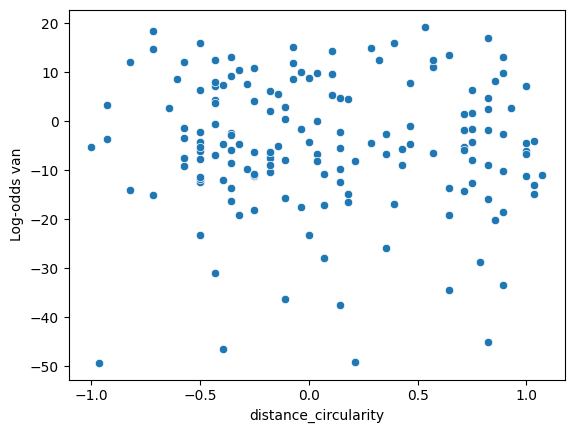

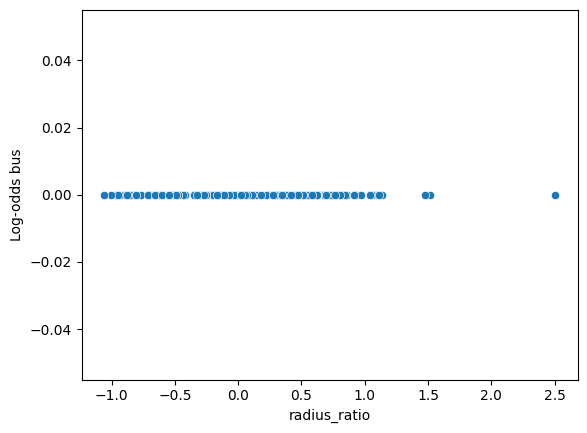

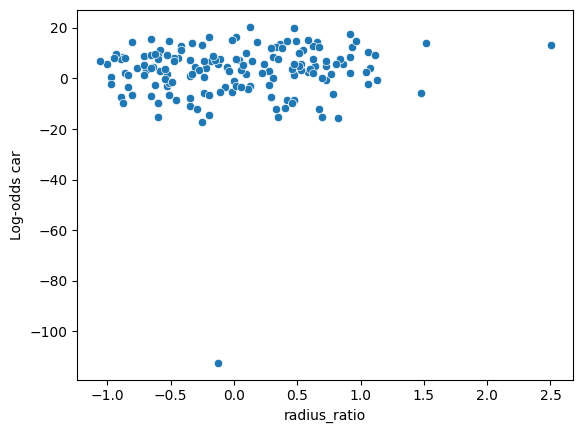

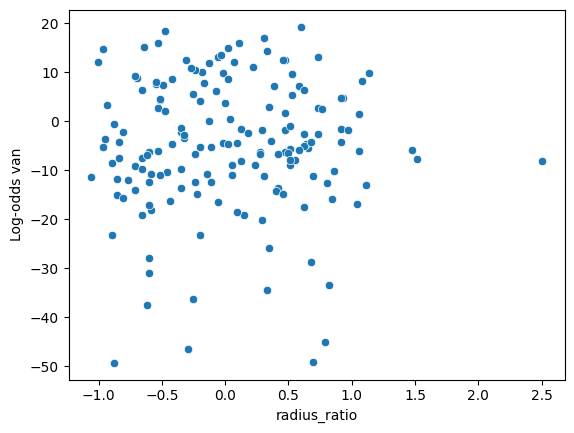

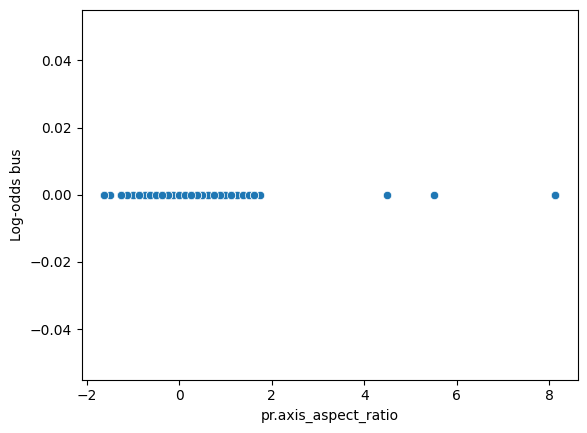

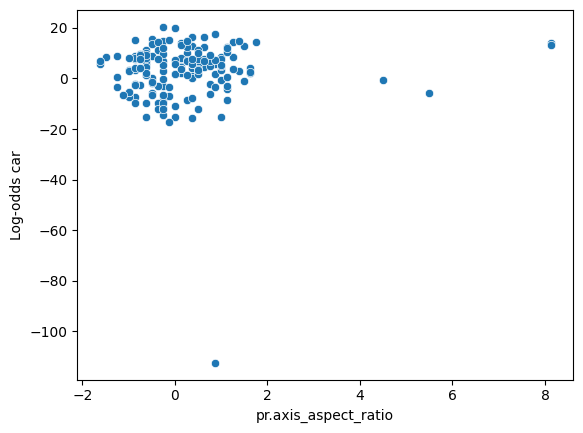

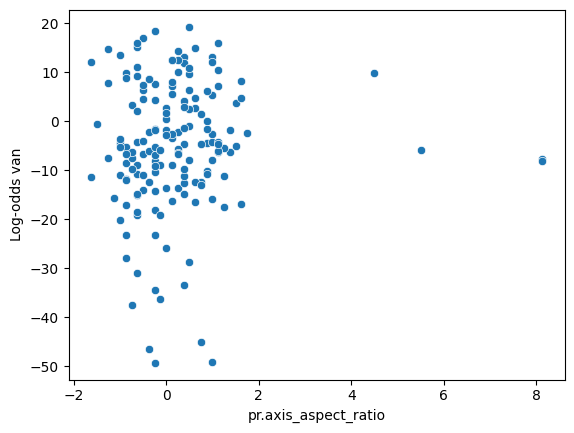

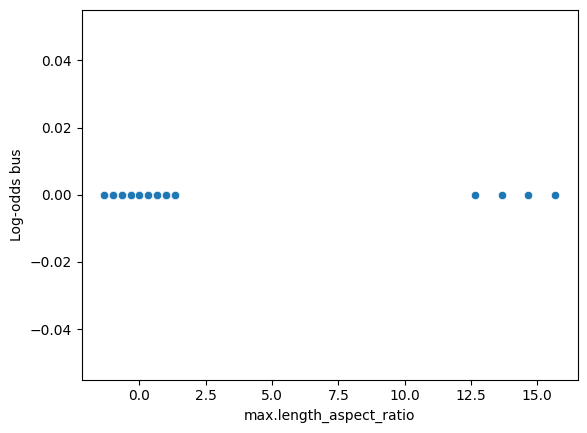

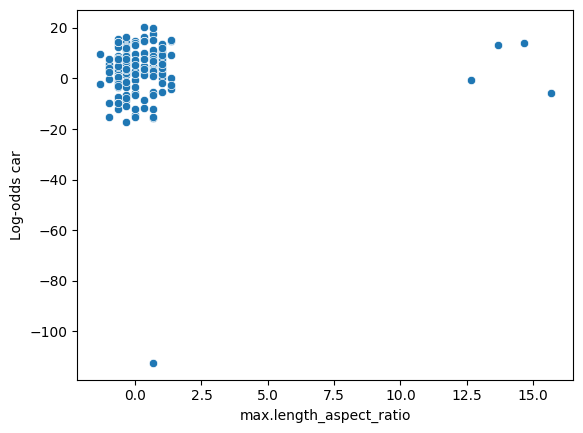

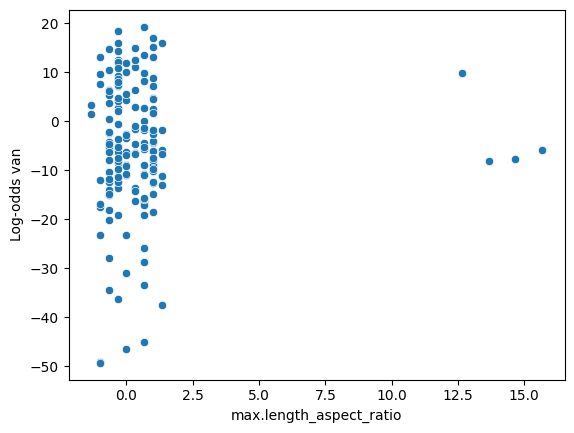

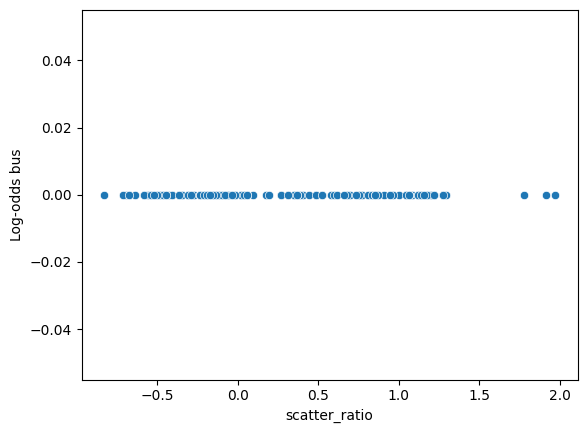

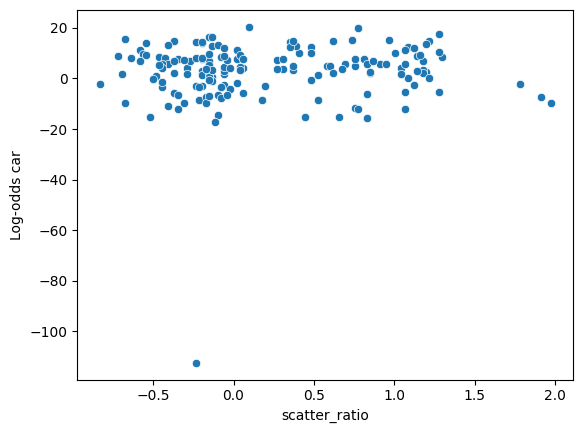

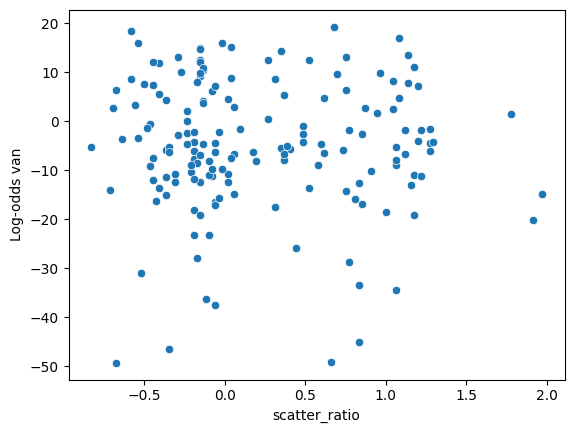

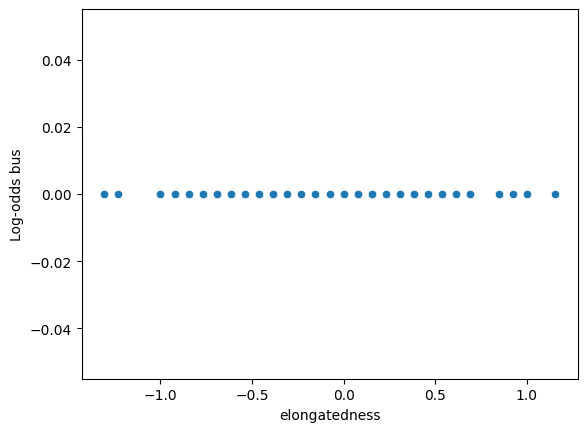

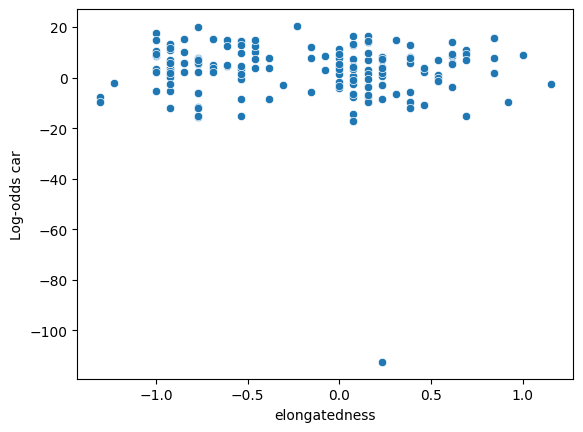

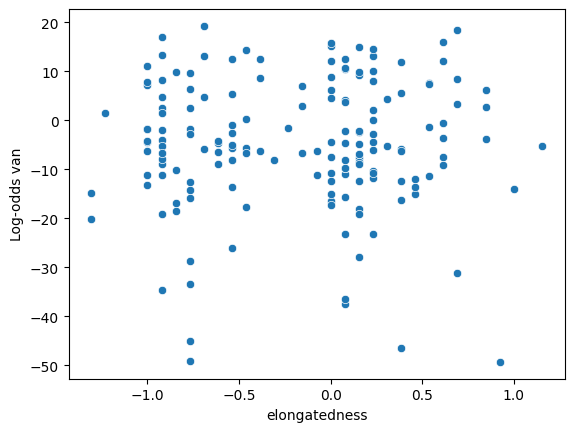

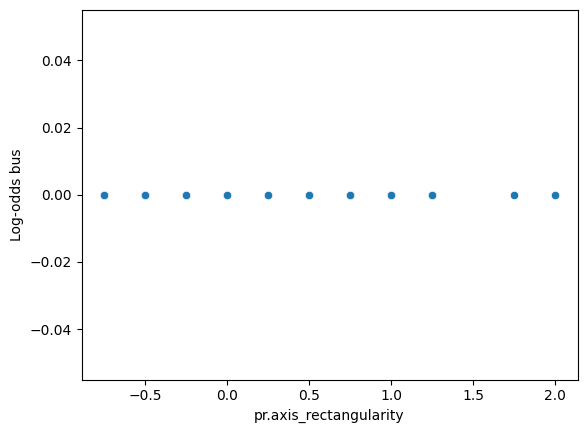

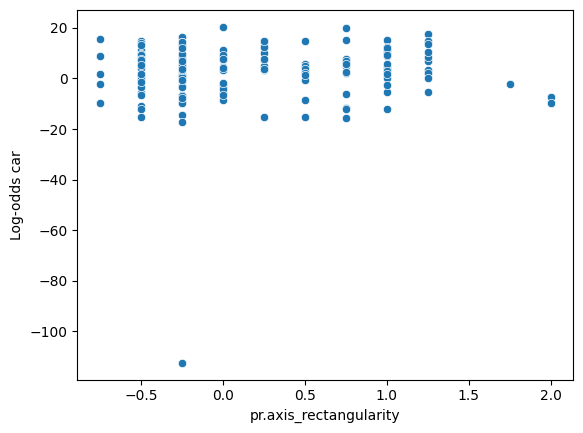

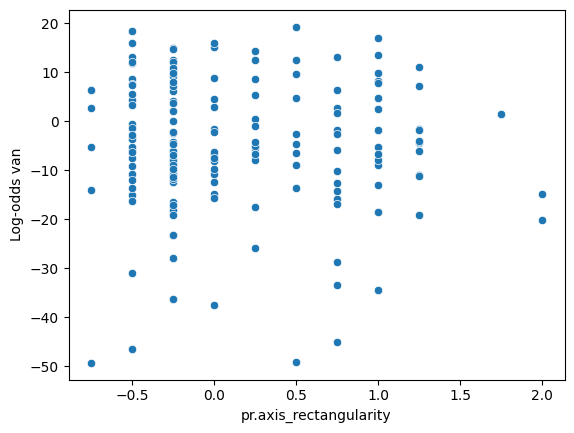

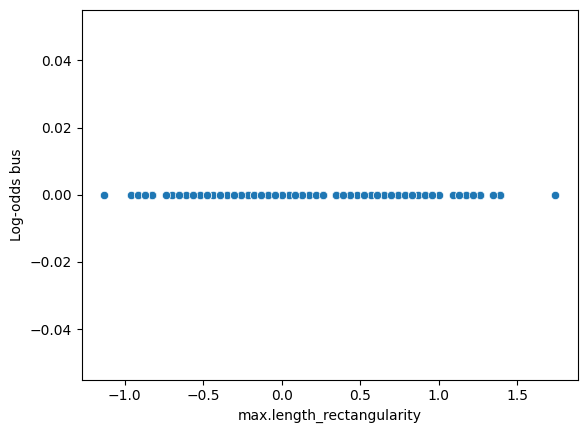

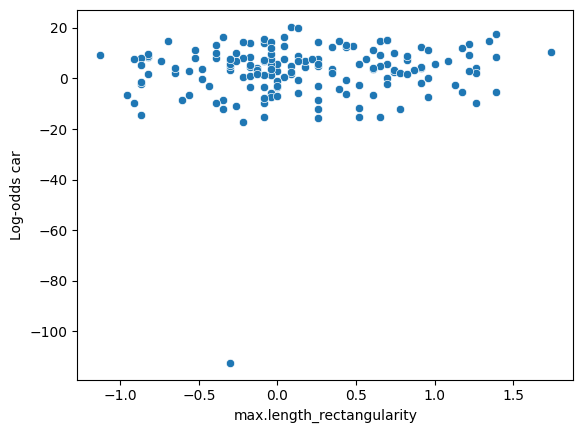

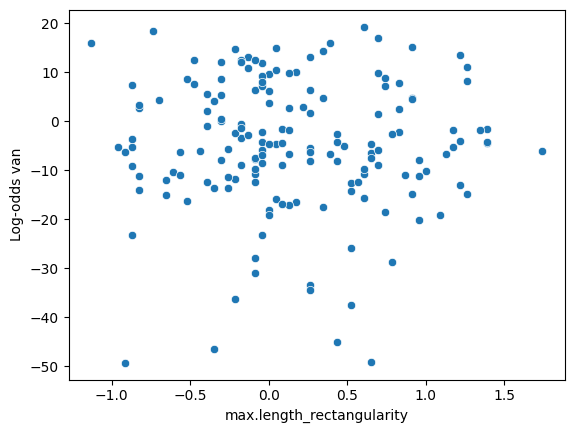

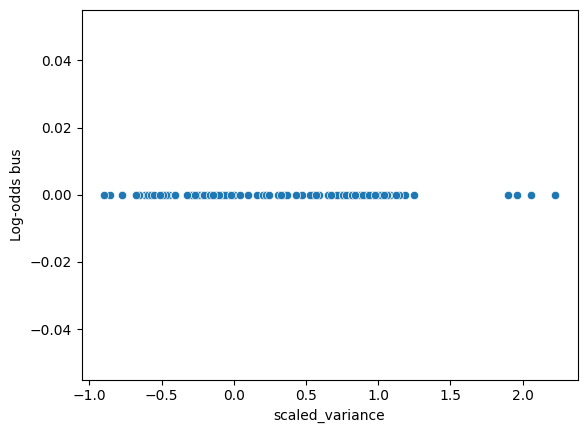

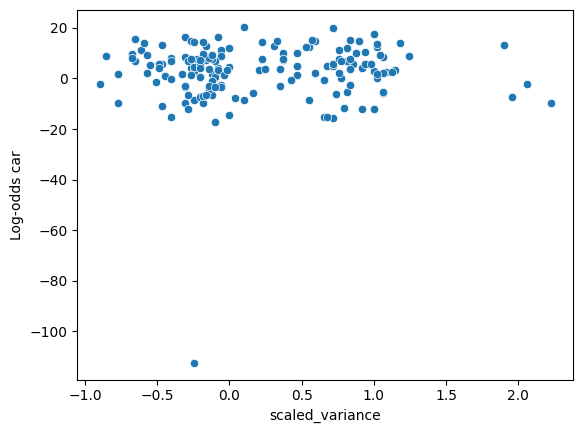

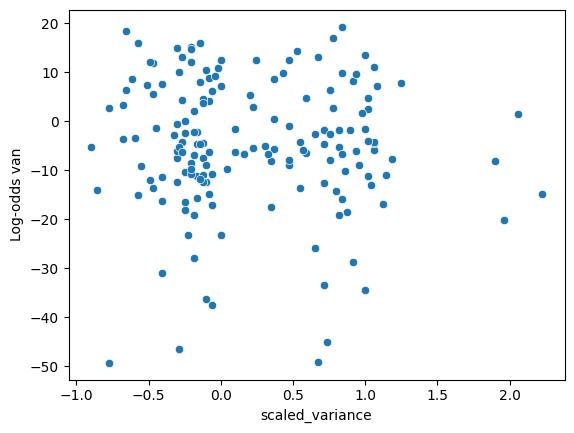

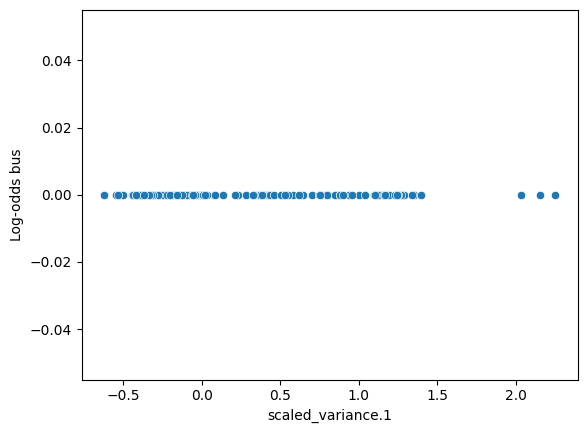

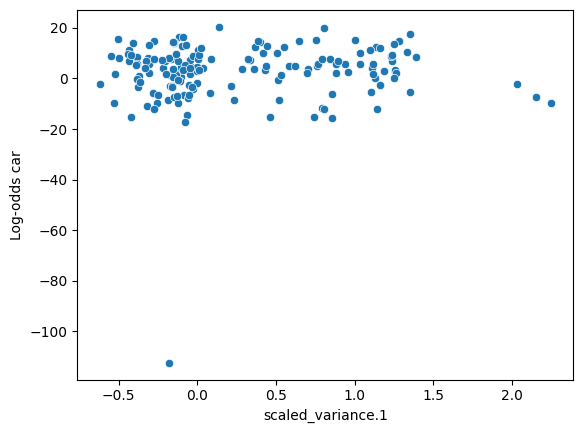

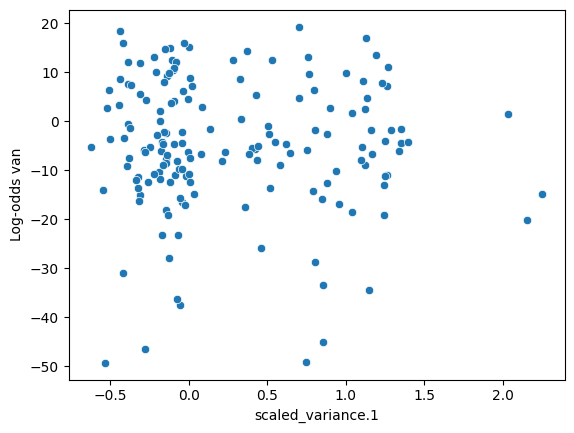

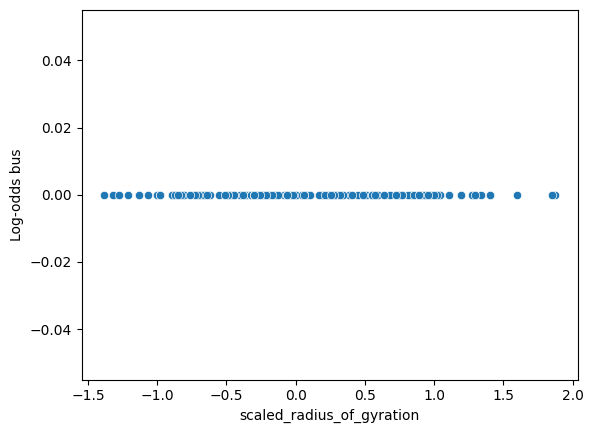

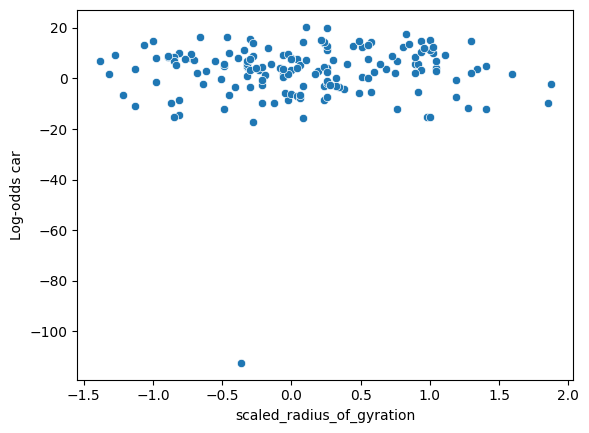

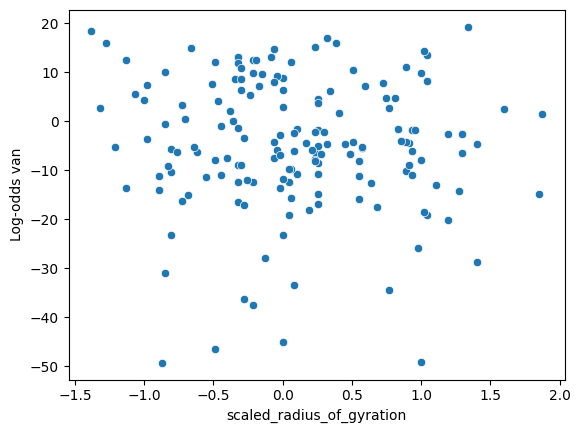

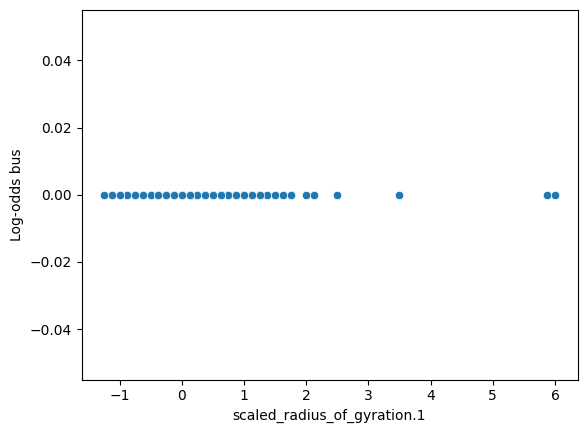

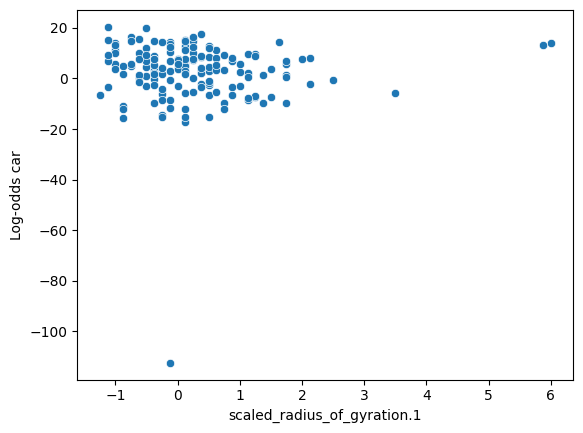

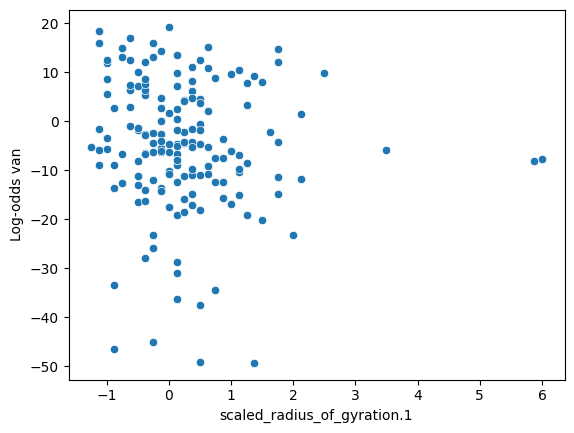

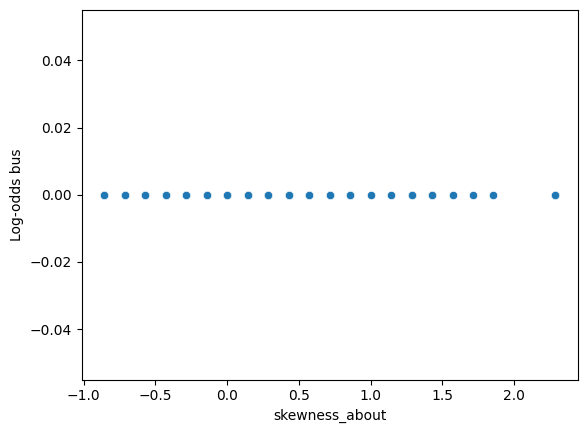

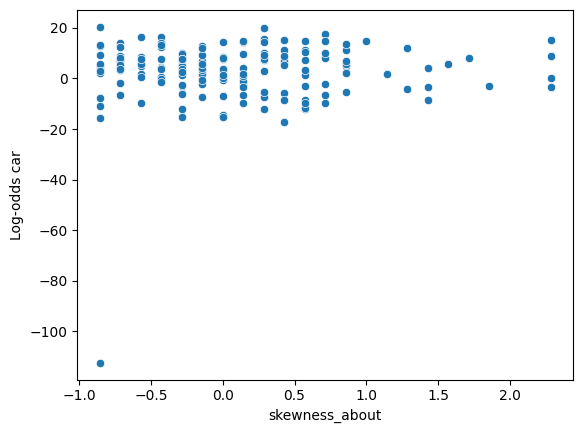

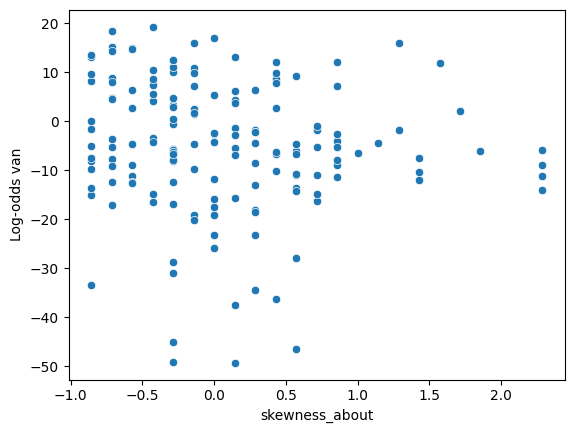

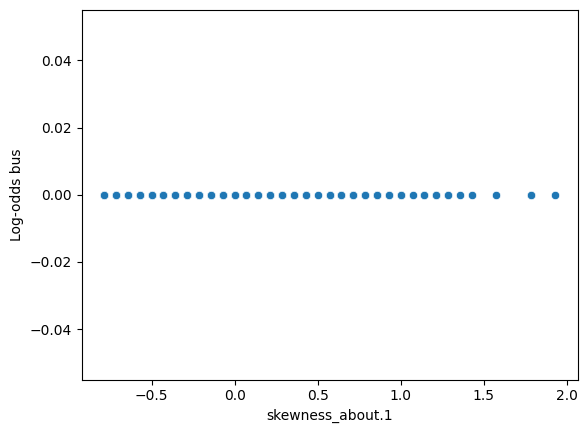

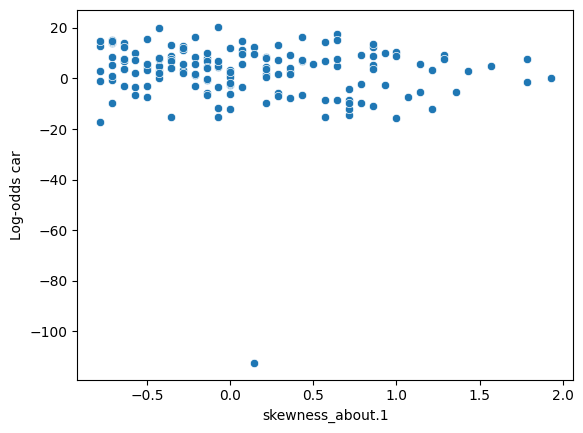

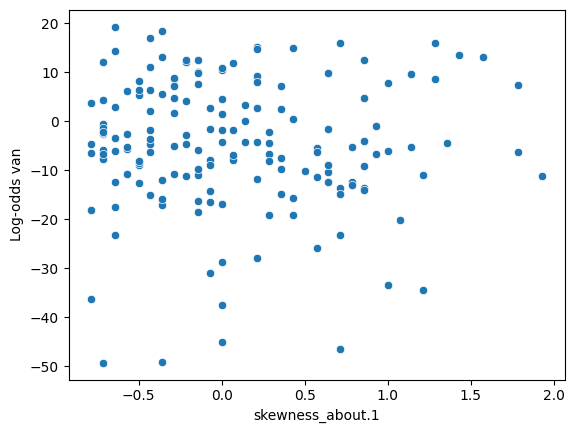

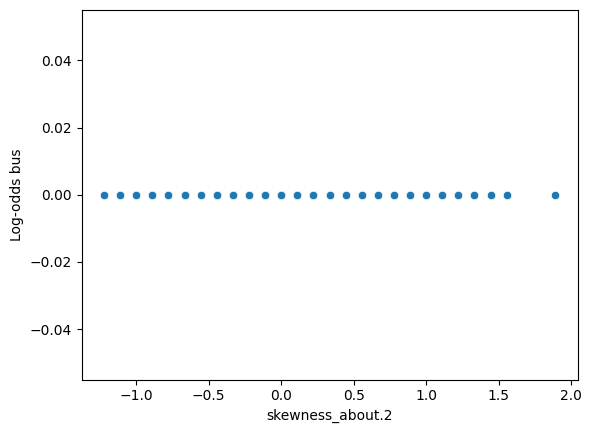

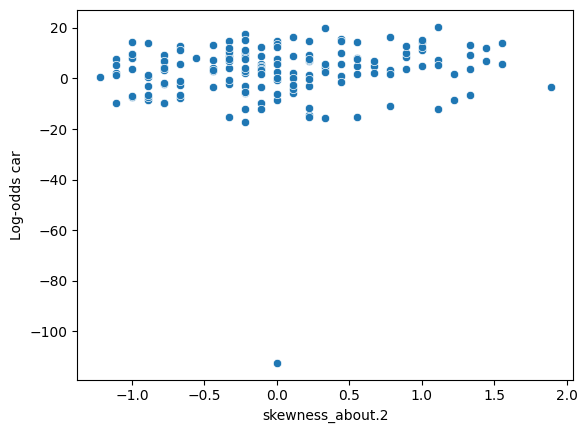

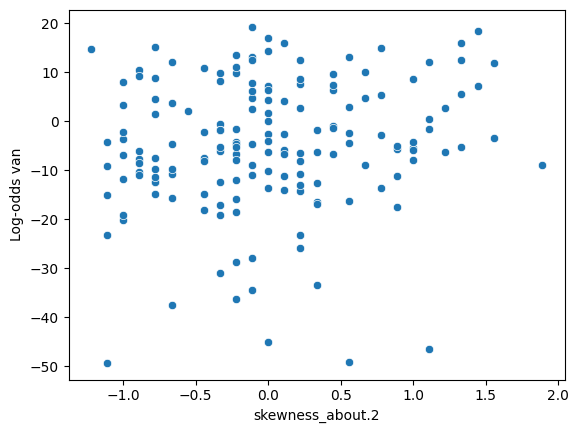

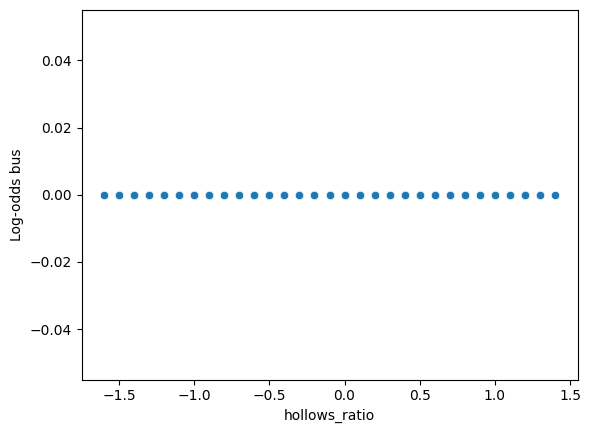

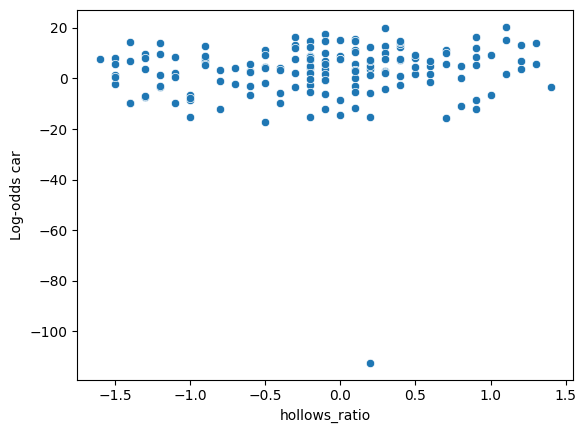

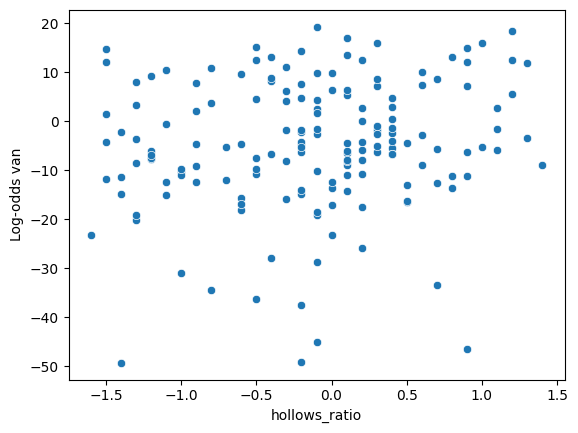

In [29]:
# check if there is a linear relationship between features and Log-odds:

reference_class = class_labels[0]
log_odds = np.log(probabilities.div(probabilities[reference_class],axis=0))
for feature in X_train_scaled.columns:
  plt.figure((6.6))
  for class_ in log_odds[1:]:
    sns.scatterplot(x=X_train_scaled[feature], y=log_odds[class_])
    plt.ylabel(f'Log-odds {class_}')
    plt.show()

# Testing SVC model for comparison:

In [54]:
# finding the right hyperparameter (since the dataset is so small, it can be used in a loop):

accuracy_dict = {}

for i in range(1,201):
  svc = SVC(C=i)
  svc.fit(X_train_scaled, y_train)
  y_test_predict = svc.predict(X_test_scaled)
  test_accuracy = np.round(accuracy_score(y_test, y_test_predict), 3)
  accuracy_dict[i] = test_accuracy

max_value = max(accuracy_dict.values())
max_key = [key for key, value in accuracy_dict.items() if value == max_value][0]
print(max_key)

8


In [70]:
svc = SVC(C=8)
svc.fit(X_train_scaled, y_train)

SVC(C=8)

In [131]:
evaluate_model(svc, X_test_scaled, y_test)

accuracy score : 0.994

Confusion Matrix:


,bus,car,van
bus,41,0,0
car,0,83,0
van,1,0,38


,bus,car,van
Precision_score,0.976190,1.0,1.000000
Recall_score,1.000000,1.0,0.974359
F1_score,0.987952,1.0,0.987013


# Testing Random Forest model for comparison:

In [149]:
rfc_base_model = RandomForestClassifier(random_state=SEED)
rfc_base_model.fit(X_train_scaled, y_train)
evaluate_model(rfc_base_model, X_test_scaled, y_test)

accuracy score : 0.963

Confusion Matrix:


,bus,car,van
bus,40,0,1
car,2,78,3
van,0,0,39


,bus,car,van
Precision_score,0.952381,1.000000,0.906977
Recall_score,0.975610,0.939759,1.000000
F1_score,0.963855,0.968944,0.951220


In [96]:
# check to see if randomize search of hyperparameters and cross validation can improve the random forest model performance:

n_estimators = list(np.arange(100,2001,200))
max_features = [None, 'sqrt', 'log2', 2, 4, 6, 10, 15]
max_depth = list(np.arange(10,201,10)) + [None]
min_samples_split = list(np.arange(2,11,2))
min_samples_leaf = list(np.arange(1,6,1))
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [97]:
rfc = RandomForestClassifier(random_state=SEED)
rfc_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid, n_iter=100, cv=3, n_jobs=None, verbose=3, random_state=SEED)
rfc_random.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=True, max_depth=50, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=0.917 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=50, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=0.908 total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=50, max_features=15, min_samples_leaf=5, min_samples_split=2, n_estimators=500;, score=0.963 total time=   2.2s
[CV 1/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1500;, score=0.945 total time=   2.5s
[CV 2/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1500;, score=0.935 total time=   2.5s
[CV 3/3] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1500;, score=0.954 total time=   2.5s
[CV 1/3] END boo

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, None],
                                        'max_features': [None, 'sqrt', 'log2',
                                                         2, 4, 6, 10, 15],
                                        'min_samples_leaf': [1, 3, 5],
                                        'min_samples_split': [2, 5, 8, 11],
                                        'n_estimators': [100, 300, 500, 700,
                                                         900, 1100, 1300, 1500,
                                                         1700, 1900]},
                   random_state=55, verbose=3)

In [102]:
rfc_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': False}

In [138]:
best_random = rfc_random.best_estimator_
evaluate_model(best_random, X_test_scaled, y_test)

accuracy score : 0.969

Confusion Matrix:


,bus,car,van
bus,40,0,1
car,2,79,2
van,0,0,39


,bus,car,van
Precision_score,0.952381,1.000000,0.928571
Recall_score,0.975610,0.951807,1.000000
F1_score,0.963855,0.975309,0.962963


In [150]:
(969-963)/963

0.006230529595015576

In [159]:
# running a grid search to see if we can improve model performance even further:

param_grid = {
    'n_estimators': [80, 100, 150],
    'max_features': ['log2'],
    'max_depth': [85, 90, 95],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2],
    'bootstrap': [False]
}
rfc = RandomForestClassifier(random_state=SEED)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=55), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [85, 90, 95],
                         'max_features': ['log2'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [80, 100, 150]},
             verbose=3)

In [160]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 85,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [161]:
best_grid = grid_search.best_estimator_
evaluate_model(best_grid, X_test_scaled, y_test)

accuracy score : 0.969

Confusion Matrix:


,bus,car,van
bus,40,0,1
car,2,79,2
van,0,0,39


,bus,car,van
Precision_score,0.952381,1.000000,0.928571
Recall_score,0.975610,0.951807,1.000000
F1_score,0.963855,0.975309,0.962963
